# Tutorial: Overfitting/Underfitting and Bias/Variance

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2F03_tutorial_overfitting_underfitting_bias_variance.ipynb)

Tutorial to the class [Overfitting/Underfitting and Bias/Variance](03_overfitting_underfitting_bias_variance.ipynb) 

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
- Evaluate model performance by estimating the Expected Prediction Errors (EPE) using test data.
- Same as above but with cross-validation.
- Compute and plot learning curves.
- Estimate the irreducible error and bias error.
- Improve the models by modifying the input features.
</div>

<div class="alert alert-block alert-warning">

We are going to study the temperature variations in the upper part of the equatorial ocean. Our goal is to get an estimate of the temperature as a function of depth $T = f(z)$. We are going to suppose that $f$ is linear such that $T = \alpha z + \beta$. 

</div>

## Argo profiles

To measure temperature and salinity in the ocean, the scientific community has deployed Argo Floats in all ocean basins. Argo floats look like cylinders that can adjust their density (like a submarine). They are programmed to go up and down in the ocean and measure temperature, salinity and pressure along their path. The figure below is an illustration of a typical work cycle of such a float. **Each time the Argo float moves up, it records a profile**, as illustrated in the figure below.

<img alt="Argo" src="images/argo.jpg" width="750">
Figure from Walczowski et al (2020)

### Download the data

We are going to analyze the data taken from one argo float

> ***Question***
> - Check in the `data` folder that you have a file named `nodc_13858_prof.nc`.
> - If not, you can download it from `https://data.nodc.noaa.gov/argo/gadr/data/aoml/13858/nodc_13858_prof.nc` and place it in the `data` folder. (as in [Tutorial 1](01_introduction.ipynb))


### Information about the data

- The dataset contains 48 profiles of temperature, salinity recorded at predefined pressure levels near the Equator in the Atlantic ocean : Lat: +2 deg, longitude; Lon: -14 deg. It is a subset of the  [Argo dataset](https://argo.ucsd.edu/data/)


- In our subset, there are `n_prof = 48` vertical profiles recorded between July 1997 and December 1998. At the equator, there is *no seasonal cycle* so that *all profiles are from the same distribution*. Each profile should be considered as *one coherent sample*.


- We are going to suppose that pressure in decibar is equivalent to depth in meters.


- We will focus on the upper part of the ocean (upper 100 m) which corresponds to the first 15 measurements of each profile


## Getting ready

In the cell below we import the main libraries and load the dataset in the `ds` object. We extract a subsample of pressures (depths) and temperatures that we store in the variables `x_pres` and `y_temp` respectively.  These are 2d arrays where each row correspond to one individual profile.

In [290]:
# Path manipulation module
from pathlib import Path
# Numerical analysis module
import numpy as np
# Formatted numerical analysis module
import pandas as pd
# Plot module
import matplotlib.pyplot as plt
# read netCDF files
import xarray as xr


# Set data directory
data_dir = Path('data')
argo_filename = 'nodc_13858_prof.nc'
argo_filepath = Path(data_dir, argo_filename)

# name of the temperature and pressure variables in the netcdf file
var_temp = 'temp' 
var_pres = 'pres'

# load the data
ds = xr.open_dataset(argo_filepath)

n_prof = int(ds['n_prof'][-1]) + 1
print(f'There are {n_prof} profiles in this dataset')

n_max = 15
print(f'For each profile, we are going to keep only the first {n_max} measurements')

x_pres = ds[var_pres].values[:,:n_max]
y_temp = ds[var_temp].values[:,:n_max]


There are 48 profiles in this dataset
For each profile, we are going to keep only the first 15 measurements


array([[15.5, 21.1, 26.6, 32.2, 37.8, 43.4, 49. , 54.6, 60.2, 65.8, 71.4,
        77. , 82.6, 88.2, 93.8],
       [15.5, 21.1, 26.6, 32.2, 37.8, 43.4, 49. , 54.6, 60.2, 65.8, 71.4,
        77. , 82.6, 88.2, 93.8],
       [15.5, 21.1, 26.6, 32.2, 37.8, 43.4, 49. , 54.6, 60.2, 65.8, 71.4,
        77. , 82.6, 88.2, 93.8],
       [15.5, 21.1, 26.6, 32.2, 37.8, 43.4, 49. , 54.6, 60.2, 65.8, 71.4,
        77. , 82.6, 88.2, 93.8],
       [15.5, 21.1, 26.6, 32.2, 37.8, 43.4, 49. , 54.6, 60.2, 65.8, 71.4,
        77. , 82.6, 88.2, 93.8],
       [15.5, 21.1, 26.6, 32.2, 37.8, 43.4, 49. , 54.6, 60.2, 65.8, 71.4,
        77. , 82.6, 88.2, 93.8],
       [15.5, 21.1, 26.6, 32.2, 37.8, 43.4, 49. , 54.6, 60.2, 65.8, 71.4,
        77. , 82.6, 88.2, 93.8],
       [15.5, 21.1, 26.6, 32.2, 37.8, 43.4, 49. , 54.6, 60.2, 65.8, 71.4,
        77. , 82.6, 88.2, 93.8],
       [15.5, 21.1, 26.6, 32.2, 37.8, 43.4, 49. , 54.6, 60.2, 65.8, 71.4,
        77. , 82.6, 88.2, 93.8],
       [15.5, 21.1, 26.6, 32.2, 37.8,

In [29]:
ds.head()

<xarray.Dataset> Size: 3kB
Dimensions:                       (n_prof: 5, n_param: 2, n_levels: 5,
                                   n_calib: 1, n_history: 0)
Dimensions without coordinates: n_prof, n_param, n_levels, n_calib, n_history
Data variables: (12/59)
    data_type                     object 8B ...
    format_version                object 8B ...
    handbook_version              object 8B ...
    reference_date_time           object 8B ...
    date_creation                 object 8B ...
    date_update                   object 8B ...
    ...                            ...
    history_parameter             (n_history, n_prof) object 0B ...
    history_start_pres            (n_history, n_prof) float32 0B ...
    history_stop_pres             (n_history, n_prof) float32 0B ...
    history_previous_value        (n_history, n_prof) float32 0B ...
    history_qctest                (n_history, n_prof) object 0B ...
    crs                           int32 4B ...
Attributes: (12/49)
    title:                           Argo float vertical profile
    institution:                     FR GDAC
    source:                          Argo float
    history:                         2019-10-20T09:08:09Z boyer convAGDAC.f90...
    references:                      https://www.nodc.noaa.gov/argo/
    user_manual_version:             3.1
    ...                              ...
    time_coverage_end:               1998-12-27T20:00:25Z
    time_coverage_duration:          point
    time_coverage_resolution:        point
    gadr_ConventionVersion:          GADR-3.0
    gadr_program:                    convAGDAC.f90
    gadr_programVersion:             1.2

In [16]:
print(x_pres,"\n")
print(y_temp)
print(x_pres.shape,"\n") #(48, 15) # each row, corresponds to 1 profile that is why 48 rows
print(y_temp.shape) #(48, 15)

[[15.5 21.1 26.6 32.2 37.8 43.4 49.  54.6 60.2 65.8 71.4 77.  82.6 88.2
  93.8]
 [15.5 21.1 26.6 32.2 37.8 43.4 49.  54.6 60.2 65.8 71.4 77.  82.6 88.2
  93.8]
 [15.5 21.1 26.6 32.2 37.8 43.4 49.  54.6 60.2 65.8 71.4 77.  82.6 88.2
  93.8]
 [15.5 21.1 26.6 32.2 37.8 43.4 49.  54.6 60.2 65.8 71.4 77.  82.6 88.2
  93.8]
 [15.5 21.1 26.6 32.2 37.8 43.4 49.  54.6 60.2 65.8 71.4 77.  82.6 88.2
  93.8]
 [15.5 21.1 26.6 32.2 37.8 43.4 49.  54.6 60.2 65.8 71.4 77.  82.6 88.2
  93.8]
 [15.5 21.1 26.6 32.2 37.8 43.4 49.  54.6 60.2 65.8 71.4 77.  82.6 88.2
  93.8]
 [15.5 21.1 26.6 32.2 37.8 43.4 49.  54.6 60.2 65.8 71.4 77.  82.6 88.2
  93.8]
 [15.5 21.1 26.6 32.2 37.8 43.4 49.  54.6 60.2 65.8 71.4 77.  82.6 88.2
  93.8]
 [15.5 21.1 26.6 32.2 37.8 43.4 49.  54.6 60.2 65.8 71.4 77.  82.6 88.2
  93.8]
 [15.5 21.1 26.6 32.2 37.8 43.4 49.  54.6 60.2 65.8 71.4 77.  82.6 88.2
  93.8]
 [15.5 21.1 26.6 32.2 37.8 43.4 49.  54.6 60.2 65.8 71.4 77.  82.6 88.2
  93.8]
 [15.5 21.1 26.6 32.2 37.8 43.4 49.  54.


> ***Question***
> - Check in the `ds` object that the unit of temperature is degree Celsius and the unit of pressure is decibar. In the remainder of the tutorial, we will consider that the pressure in decibar is equivalent to the depth in meters.
> - Pick the first profile `ip = 0`, and plot the temperature as a function of depth. Don't forget the labels!

In [24]:
#Additional : by following this you can print the entire info for a variable
ds['pres']

<xarray.DataArray 'pres' (n_prof: 48, n_levels: 102)> Size: 20kB
array([[  15.5,   21.1,   26.6, ..., 1025.6, 1036.8, 1048. ],
       [  15.5,   21.1,   26.6, ..., 1031.2, 1042.4, 1053.6],
       [  15.5,   21.1,   26.6, ..., 1031.2, 1042.4,    nan],
       ...,
       [  15.5,   21.1,   26.6, ...,    nan,    nan,    nan],
       [  15.5,   21.1,   26.6, ...,    nan,    nan,    nan],
       [  15.5,   21.1,   26.6, ...,    nan,    nan,    nan]], dtype=float32)
Dimensions without coordinates: n_prof, n_levels
Attributes:
    long_name:       Sea water pressure, equals 0 at sea-level
    standard_name:   sea_water_pressure
    units:           decibar
    valid_min:       0.0
    valid_max:       12000.0
    C_format:        %7.1f
    FORTRAN_format:  F7.1
    resolution:      1.0
    axis:            Z

In [27]:
# your answer here
print("Temperature Units:", ds['temp'].attrs.get('units','No units attribute'),"\n",)
print("Temperature Units:", ds['pres'].attrs.get('units','No units attribute'))
#ds['temp'].attrs.get('standard_name') so following the same syntax we can get any info

Temperature Units: degree_Celsius 

Temperature Units: decibar


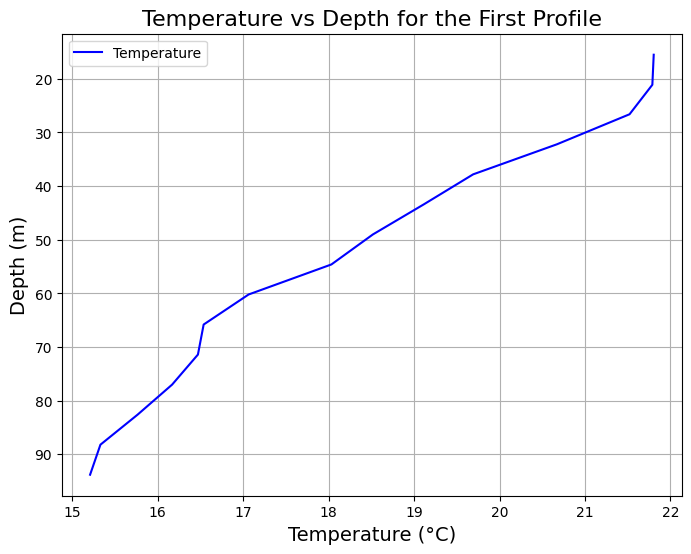

In [157]:
ip = [0]
profile_1_depth = x_pres[ip]
profile_1_temp = y_temp[ip]
Temperature_1 = profile_temp.T
Depth_1 = profile_depth.T

plt.figure(figsize=(8, 6))
plt.plot(Temperature_1, Depth_1, label='Temperature', color='blue')
plt.gca().invert_yaxis()  # Invert y-axis to have depth increasing downwards
plt.title('Temperature vs Depth for the First Profile', fontsize=16)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


> ***Question***
> - Do a linear regression to estimate the coefficients $\alpha$ and $\beta$ (as explained above) with this profile as training data.

In [167]:
# your answer here

#For profile1

from sklearn.linear_model import LinearRegression

#Taking care of NaN values if any
valid_indices = ~np.isnan(Temperature_1) & ~np.isnan(Depth_1) #~.isnan = means not NaN
temperature_1 = Temperature_1[valid_indices]
depth_1 = Depth_1[valid_indices]

# Preparing the input matrix and output vector
X = depth_1.reshape(-1, 1) # 2D array for input matrix # Independent
y = temperature_1 #target vector
#print(X.shape) #2D array
#print(y.shape) #1D array

# Initialize the linear regression model
model = LinearRegression(fit_intercept=True)

# Fit the model to the data
model.fit(X, y)

# Extract the estimated coefficients
intercept = model.intercept_
slope = model.coef_[0]

print(f"Intercept: {intercept}")
print(f"Slope: {slope}")


Intercept: 23.40384864807129
Slope: -0.09445885568857193


> ***Question***
> - Plot your linear regression on top of the raw data. Don't forget the labels

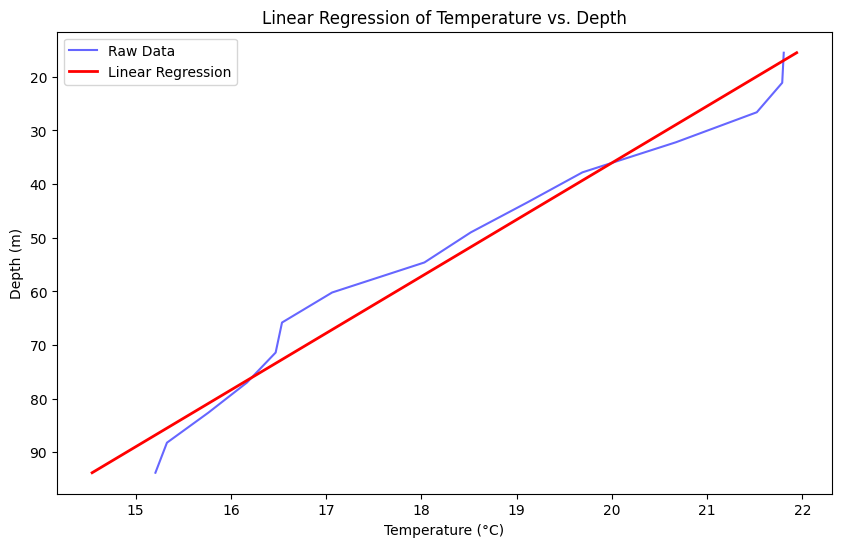

In [168]:
# your answer here
temp_1_pred = model.predict(X)
plt.figure(figsize=(10, 6))
plt.plot(temperature_1, depth_1, color='blue', label='Raw Data', alpha=0.6)
plt.plot(temp_1_pred, depth_1, color='red', label='Linear Regression', linewidth=2)
plt.gca().invert_yaxis()  # Invert y-axis because depth increases downwards
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (m)')
plt.title('Linear Regression of Temperature vs. Depth')
plt.legend()
plt.show()

> ***Question***
> - What is the training score $R^2$ for this linear regression?
> - What do you think of this value of $R^2$?

In [169]:
# your answer here
r_squared = model.score(X, y)
print("R^2 Score (using Scikit-Learn):","\n",r_squared)

R^2 Score (using Scikit-Learn): 
 0.9720957279205322


your answer here : The R score of 0.97 suggests a fairly strong positive linear relationship

> ***Question***
> - Select a random profile `ip2` between `1` and `n_prof -1`.
> - We are going to use this new profile as testing set. What is the testing score $R^2$?
> - Are you overfitting?  Justify your answer

In [224]:
# your answer here
ip2 = int(np.random.rand()*(n_prof - 2)) + 1

print(f"Working with profile number: ip2 = {ip2}")

#Extracting the temp and depth data for profile 2
temperature_var = y_temp[ip2]
depth_var = x_pres[ip2]

#Removing the NaN values
valid_indices = ~np.isnan(temperature_var) & ~np.isnan(depth_var) #~.isnan = means not NaN
temperature_var = temperature_var[valid_indices]
depth_var = depth_var[valid_indices]

# Preparing the input matrix and output vector
X = depth_var.reshape(-1, 1) # 2D array for input matrix
y = temperature_var
#print(X.shape) #2D array
#print(y.shape) #1D array

# Initialize the linear regression model
model = LinearRegression(fit_intercept=True)

# Fit the model to the data
model.fit(X, y)

# Extract the estimated coefficients
intercept = model.intercept_
slope = model.coef_[0]

print(f"Intercept: {intercept}")
print(f"Slope: {slope}")

r_squared = model.score(X, y)
print("R^2 Score (using Scikit-Learn):","\n",r_squared)


Working with profile number: ip2 = 20
Intercept: 36.332481384277344
Slope: -0.2445107400417328
R^2 Score (using Scikit-Learn): 
 0.9065961837768555


Answer: The model is over fitting, as there is a discrepency between the R value predicted on training and test data. It is higher from training data, while lower for test data.

R2 value for training data (Profile 1) :  0.9720957279205322

R2 values for test data:.
- Profile 15 : 0.8662625551223755
- Profile 23 : 0.8812008500099182
- Profile 28 : 0.8569755554199219
- Profile 30 : 0.8777925968170166
- Profile 2  : 0.9426303505897522
    
    


## Learning curve

In general, there are two possible reasons that can explain the fact that we are overfitting the data. Either we do not have enough data or the model is to complicated. Since linear regression is one of the simplest possible models, we will focus more on the amount of data needed to extract a general law for this problem. This can be achieved with a learning curve.

### What is a sample?

A key assumption regarding datasets is that each point should be Independent Identically Distributed (also noted [*iid*](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)). This is in practice rarely true and in fact, for our dataset, this is clearly not the case because the points within a profile are correlated (i.e. not independent). There are then two possible approaches

- Treat each profile as a coherent block of data (the new sample size is then a whole profile rather than one data point)
- Shuffle the entire data set

In this tutorial, we will adopt the first strategy to design well balanced **training** and **testing** sets. So keep in mind that for this example ***one sample = one profile***. Note that this type of consideration is not specific to this dataset: if you are aware of a pre-existing structure (seasonality, space proximity, etc), you will need to keep it in mind to build your train and test data.



> ***Question***
> - Compute and plot a learning curve. To do so:
>   - Partition your dataset into `n_train` samples for training and `n_test  = n_prof - n_train` samples for testing.
>   - Define a list of train period of increasing lengths
>   - Loop over these train periods to iteratively:
>     - Select data for this train period
>     - Train the model
>     - Compute the train error from the train data for the train period
>     - Compute the test error from the test data for the test period
>     - Save both errors
>   - Plot both errors curves
> - Interpret the results.

In [196]:
X = x_pres #2D array -- Input matrix = depth
y = y_temp.reshape(-1,1)  #1D array -- target vector = temperature
X.shape
y.shape


43

[ 5  8 12 16 19 23 27 30 34 38]


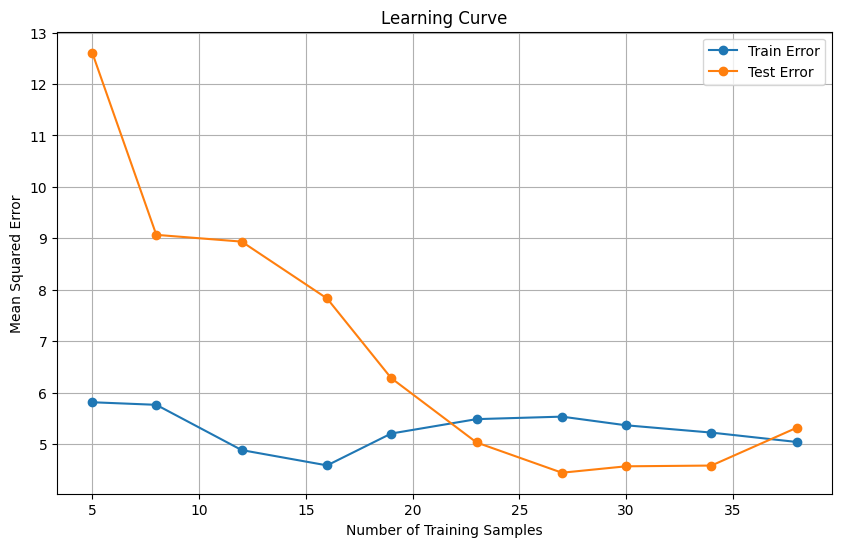

In [248]:
# your answer here
from sklearn.metrics import mean_squared_error

# partitioning data into training and testing
n_train = int(0.8 * n_prof) 
n_test = n_prof - n_train

train_periods = np.linspace(5, n_train, 10, dtype=int)
print(train_periods)
train_errors = []
test_errors = []

X = x_pres #2D array -- Input matrix = depth
y = y_temp  #1D array -- target vector = temperature

#X.shape (4896, 1)
#y.shape (48, 102)
#for i in train_periods:

for i in train_periods:
    #select the training data
    X_train = X[:i] #selects the 1st training period i.e 5 for my case
    y_train = y[:i]

    # Select testing data
    X_test = X[i:] # selects the other profiles expect for training  when 5 training periods, choosing 43 periiods to tes
    y_test = y[i:]

    #Train the model
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train,y_train)

    # Compute train error
    y_train_pred = model.predict(X_train)
    train_error = mean_squared_error(y_train, y_train_pred)
    train_errors.append(train_error)

    # Compute test error
    y_test_pred = model.predict(X_test) 
    test_error = mean_squared_error(y_test, y_test_pred)
    test_errors.append(test_error)
    
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_periods, train_errors, label='Train Error', marker='o')
plt.plot(train_periods, test_errors, label='Test Error', marker='o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

Answer : From the learning curve, we can deduce that when the model is fit using atleast 25 profiles as training samples the model starts generalizing i.e, it produces similar R2 values for both test and training data.

## Estimating the expected prediction error with cross-validation

> ***Question***
> - Perform a $k$-fold cross-validation of your own by repeating the above estimation of the test error on all samples. To do so:
>   - Use the `split` method of a `sklearn.model_selection.KFold` object initialized with the `n_splits` option to get a sequence train and test indices over which to loop.
>   - For each pair of train and test indices:
>     - Select the train and test data from the input and output data;
>     - Fit the model using the train data;
>     - Use the fitted model to predict the target from the test inputs;
>     - Estimate the $R^2$ from the test output.
>   - Average the $R^2$ estimates.

In [313]:
# your answer here

from sklearn.model_selection import KFold
#Input matrix and output vector

X = x_pres #2D array -- Input matrix = depth
y = y_temp  #1D array -- target vector = temperature

#getting the training and testing samples
kf = KFold(n_splits=5,shuffle=True, random_state=10) #kf is the 
#kf.get_n_splits(X)

# Store the R² scores for each fold
r2_score = []
r2_score_train = []

for i, (train_index, test_index) in enumerate(kf.split(X),1):  #enumerate(kf.split(X),1) =enumerate(5,1) ,1 means start the indexing from 1
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

    #for j on
    #select the training data
    X_train = X[train_index] #selects the 1st training period i.e 5 for my case
    y_train = y[train_index]
    
    # Select testing data
    X_test = X[test_index] # selects the other profiles expect for training  when 5 training periods, choosing 43 periiods to tes
    y_test = y[test_index]

    #Train the model 
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train,y_train)

    # Compute the target from trained model using the test fold dataset
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    # Compute R² score _test
    r2 = model.score(y_test, y_test_pred)
    r2_score.append(r2)
    print(f"  R² score for this fold: {r2}")

    # Compute R2 score_train
    r2_train = model.score(y_train, y_train_pred)
    r2_score_train.append(r2_train)
    print(f"  R² train score for this fold: {r2}")


print("\n" , "r2 test score list;", r2_score )   
print("\n" , "r2 train score list;", r2_score_train)  

# Calculate average R² score over all folds
mean_r2 = np.mean(r2_scores)
print(f"\nAverage R² score across all folds: {mean_r2}")
#cross validate mean to train the model by using training data and predicting the target using test data and then computing the R2, and it is anticipated that R2 values will remain nearly same for every fold, to have the confidence in training


Fold 1:
  Train: index=[ 0  1  2  4  5  8  9 10 11 12 13 14 15 16 17 18 19 21 22 24 25 26 27 28
 29 31 32 33 34 36 37 38 39 41 43 44 46 47]
  Test:  index=[ 3  6  7 20 23 30 35 40 42 45]
  R² score for this fold: -85142519808.0
  R² train score for this fold: -85142519808.0
Fold 2:
  Train: index=[ 0  1  3  4  5  6  7  8  9 11 12 13 14 15 16 17 19 20 22 23 24 25 26 28
 29 30 33 35 36 39 40 41 42 43 44 45 46 47]
  Test:  index=[ 2 10 18 21 27 31 32 34 37 38]
  R² score for this fold: -39542923264.0
  R² train score for this fold: -39542923264.0
Fold 3:
  Train: index=[ 0  2  3  4  6  7  8  9 10 11 14 15 16 18 20 21 23 24 25 27 28 29 30 31
 32 34 35 36 37 38 39 40 41 42 44 45 46 47]
  Test:  index=[ 1  5 12 13 17 19 22 26 33 43]
  R² score for this fold: -68274921472.0
  R² train score for this fold: -68274921472.0
Fold 4:
  Train: index=[ 0  1  2  3  5  6  7  8  9 10 12 13 15 17 18 19 20 21 22 23 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 40 41 42 43 45]
  Test:  index=[ 4 11 14 16 24 3

c:\users\hammad\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\hammad\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Confusion: I do not understand why the R values are so negative 

> ***Question***
> - Verify your results using the `cross_val_score` function of `sklearn.model_selection` with the appropriate value for the `cv` option.
> - How does the $R^2$ estimate from the cross-validation compare to your estimation above?

In [9]:
# answer cell


Answer: 

## Irreducible error, Bias error

This data set is special because all measurements are at the same depth. We can use this property to measure specific quantities such as the irreducible error or the bias error.

> ***Question***
> - In one single figure, plot:
>    - All sample points with small dots
>    - The mean temperature at each depth
>    - your best linear regression
>  - Propose a graphical interpretation for the irreducible error and the bias error
>  - Where can you read the irreducible error on the learning curve?

In [371]:
regression_line
individual_depths.shape
depth.shape
temp_pred.shape

(48, 15)

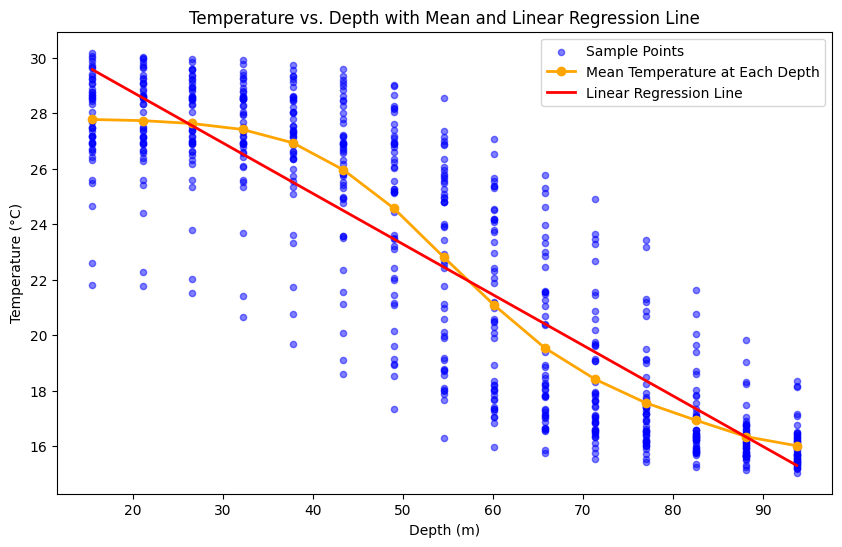

In [379]:
# your answer here
temperature = y_temp
depth = x_pres

plt.figure(figsize=(10, 6))

#plotting all sample points
plt.scatter(depth, temperature, color='blue', alpha=0.5, s=20, label="Sample Points")

#mean temperature at each depth
individual_depths = np.unique(depth)
mean_temperature = [np.mean(temperature[depth == d]) for d in individual_depths]
plt.plot(unique_depths, mean_temperature, color='orange', marker='o', linestyle='-', linewidth=2, label="Mean Temperature at Each Depth")

# Fit a linear regression model
#X = depth # 2D array for input matrix
#y = temperature
X_combined = depth.flatten().reshape(-1, 1)  # Flatten depths and reshape to 2D
y_combined = temperature.flatten()  # Flatten temperatures into a 1D array
model = LinearRegression()
model.fit(X_combined, y_combined)
temp_pred = model.predict(X_combined)
plt.plot(X_combined, temp_pred, color='red', linewidth=2, label="Linear Regression Line")


plt.xlabel("Depth (m)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature vs. Depth with Mean and Linear Regression Line")
plt.legend()
plt.show()

Answer: Graphically we can visualize the two errors in the following way:
Bias : Visually it can be deduced as the difference between the regression line(red) and the Mean temperature line at each depth (orange).
Irreducible error: The scatter of blue points above and below the regression line indicates the Irreducible error

Answer: For identifying the irreducible error on the learning curve, it can be identfied as the floor or lower bound of the error. As by definition irreducible error as the name suggest could not be remove no matter how much we add to the complexiblility of the model.

> ***Question***
> - In order to verify that the data is Independent Identically Distributed, plot the variance of the temperature at each depth.
> - What do you conclude?

In [382]:
temperature.shape

(48, 15)

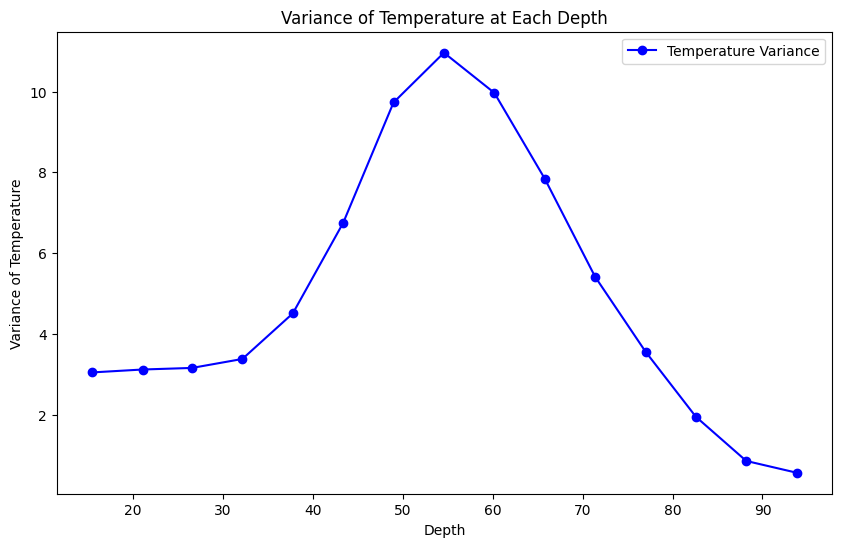

In [383]:
# Calculate the variance of temperature at each depth
temperature_variance = np.var(temperature, axis=0)
# Create a plot for the variance of temperature at each depth
plt.figure(figsize=(10, 6))
plt.plot(depth[0], temperature_variance, marker='o', color='blue', linestyle='-', label='Temperature Variance')

# Label the plot
plt.xlabel("Depth")
plt.ylabel("Variance of Temperature")
plt.title("Variance of Temperature at Each Depth")
plt.legend()
plt.show()

Answer : If the temperature data is independent identically distributed then, the variance at each depth should have remained approximately constant, however that is not the case, so the temperature data is not IID.

## Beyond a linear model

We consider the full depth of the ocean and so do no restrict ourselves to the first 100 m.

> ***Question***
> - Look at the whole temperature data. Two profiles have a lot of NaNs. Remove them. What would be a good depth to keep as many data points as possible?
> - Do a linear regression for the full dataset and plot it. Do you observe a bias error?
> - Add input features in the form of powers of $z$ and use the linear regression method of scikit-learn to fit a function of the type $f(z) = a_0 + a_1 z + a_2 z^2 ...$. Do you observe a reduction of the bias?
> - Do you think that with this dataset, going from a linear fit to a polynomial fit will increase the variance error? why? 

In [11]:
# your answer here

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>